In [277]:
%pylab inline
import pandas as pd
import h5py as h5
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold,cross_val_score, train_test_split
from sklearn.grid_search import GridSearchCV

Populating the interactive namespace from numpy and matplotlib


In [201]:
import warnings
warnings.filterwarnings('ignore')

# Final - Exploring Demographics

The goal is to see if any clusters exist for panelists who have purchased any yogurt.

In [153]:
weekMap = '../Final/IRI Week translation.csv'
weekKey = pd.read_csv(weekMap,parse_dates={'DateStart':[1], 'DateEnd':[2]})
weekKey.columns

Index([u'DateStart', u'DateEnd', u'IRI Week', u'WeekOfYear', u'Month',
       u'Year'],
      dtype='object')

### Load Data

In [154]:
datafile = '../Final/yogurt.h5'

In [155]:
with h5.File(datafile,'r') as hf:
    print hf.keys()

[u'delivery_stores', u'demos', u'drug', u'groc', u'panel', u'upc2008']


In [156]:
panel = pd.read_hdf(datafile,'panel')
demo = pd.read_hdf(datafile,'demos')

In [157]:
print panel.columns, '\n',demo.columns
print len(panel), len(demo)

Index([u'COLUPC', u'DOLLARS', u'IRI_KEY', u'MINUTE', u'OUTLET', u'PANID',
       u'UNITS', u'WEEK', u'file'],
      dtype='object') 
Index([u'ALL_TVS', u'Age Group Applied to Female HH',
       u'Age Group Applied to Male HH', u'CABL_TVS', u'COUNTY',
       u'Children Group Code', u'Combined Pre-Tax Income of HH', u'EXT_FACT',
       u'Education Level Reached by Female HH',
       u'Education Level Reached by Male HH', u'FIPSCODE', u'Family Size',
       u'Female Working Hour Code', u'HH_AGE', u'HH_EDU', u'HH_OCC',
       u'HH_RACE', u'IRI Geography Number', u'Language',
       u'Male Working Hour Code', u'Marital Status', u'Number of Cats',
       u'Number of Dogs', u'Occupation Code of Female HH',
       u'Occupation Code of Male HH', u'Panelist ID', u'RACE3',
       u'Type of Residential Possession', u'Year', u'ZIPCODE', u'filename',
       u'yearID'],
      dtype='object')
1609107 74592


COLUPC is used to tie to product features data

(Collapsed UPC). This is the UPC which matches the internal form (e.g. private label collapsed). The information in COLUPC is the same as in the combination of SY, GE, VEND, ITE.

This is the combination of a upc’s system (2 digits), generation (1 digit), vendor (5 digits) and item (5 digits) fields. See product description section for an explanation of these fields. No leading zeroes are shown.

In [158]:
panel.COLUPC.head()

0    17047000300
1    17047000302
2    17047000650
3    17047000650
4    17047001372
Name: COLUPC, dtype: int64

In [159]:
len(str(panel.COLUPC.head()[1]))

11

## Does panel data include non-yogurt purchases?

Load product feature info and join to panel

In [160]:
datafile = '../Final/yogurtType.h5'
with h5.File(datafile,'r') as hf:
    print hf.keys()

[u'products']


In [161]:
raw_prod = pd.read_hdf(datafile,'products')
raw_prod.columns

Index([u'CALORIE LEVEL', u'FAT CONTENT', u'FLAVOR/SCENT', u'GE', u'ITEM',
       u'L1', u'L2', u'L3', u'L4', u'L5', u'L9', u'Level', u'ORGANIC INFO',
       u'PACKAGE', u'PRODUCT TYPE', u'STYLE', u'SY', u'TYPE OF YOGURT', u'UPC',
       u'VEND', u'VOL_EQ', u'file'],
      dtype='object')

There is no COLUPC column. Will need to generate COLUPC using SY, GE, VEND, ITE.

In [162]:
COLUPC = ['SY', 'GE', 'VEND', 'ITEM']
raw_prod[COLUPC].head(3)

,SY,GE,VEND,ITEM
0,7,2,20742,7011
1,0,3,70452,24101
2,7,3,20742,7013


In [163]:
prod = raw_prod.copy(True)
prod['COLUPC'] =prod[COLUPC].astype('str').apply(lambda x: ''.join(x), axis=1).astype('int')
prod['COLUPC'].head(3)

0    72207427011
1    37045224101
2    73207427013
Name: COLUPC, dtype: int64

In [164]:
prod.COLUPC.drop_duplicates().count()

10661

### Handle Duplicate Products

In [165]:
prod[['COLUPC','file']].sort_values(['COLUPC','file']).head(10)

,COLUPC,file
1497,1350493,parsed stub files
1485,1350493,parsed stub files 2007
2232,1350493,parsed stub files 2008-2011
1494,1350494,parsed stub files
1482,1350494,parsed stub files 2007
1969,1350494,parsed stub files 2008-2011
1812,1521591,parsed stub files
1790,1521591,parsed stub files 2007
2367,1521591,parsed stub files 2008-2011
1810,1521596,parsed stub files


In [166]:
prod[prod.COLUPC ==1350493].drop_duplicates()

,CALORIE LEVEL,FAT CONTENT,FLAVOR/SCENT,GE,ITEM,L1,L2,L3,L4,L5,...,PACKAGE,PRODUCT TYPE,STYLE,SY,TYPE OF YOGURT,UPC,VEND,VOL_EQ,file,COLUPC
1497,LITE,NONFAT,VANILLA,1,50493,CATEGORY - YOGURT,RFG YOGURT,GROUPE DANONE S A,DANNON CO,DANNON,...,PLASTIC CUP IN BOX,YOGURT,GRADE A,0,REGULAR,00-01-00003-50493,3,4.5,parsed stub files,1350493
1485,LITE,NONFAT,VANILLA,1,50493,CATEGORY - YOGURT,RFG YOGURT,GROUPE DANONE S A,DANNON CO,DANNON,...,PLASTIC CUP IN BOX,YOGURT,GRADE A,0,REGULAR,00-01-00003-50493,3,4.5,parsed stub files 2007,1350493
2232,LIGHT,NONFAT,VANILLA,1,50493,CATEGORY - YOGURT,RFG YOGURT,GROUPE DANONE S A,DANNON CO,DANNON LIGHT N FIT,...,PLASTIC CUP IN BOX,YOGURT,GRADE A,0,NaN,00-01-00003-50493,3,4.5,parsed stub files 2008-2011,1350493


In [167]:
prod.groupby('file')['COLUPC'].count()

file
parsed stub files              4081
parsed stub files 2007         5283
parsed stub files 2008-2011    7111
Name: COLUPC, dtype: int64

### Filter by the most recent file since it contains the most data.

In [168]:
prod = prod[prod['file']=='parsed stub files 2008-2011']

### Join product features to panel data

In [169]:
print 'Record count panel transactions:',len(panel), 'products:', len(prod)

Record count panel transactions: 1609107 products: 7111


Add 'IsYogurtPurchase' column to indicate transactions where yogurt was purchased.

In [170]:
prod['IsYogurtPurchase'] = True

In [171]:
sales = pd.merge(pd.merge(panel, prod[['COLUPC','IsYogurtPurchase']], how='left', on='COLUPC'),
                 weekKey,how='inner', left_on='WEEK', right_on='IRI Week')

### Verify data assumptions

Ensure that all the panelist data for yogurt includes yogurt purchases.


In [172]:
# were there any panelists that never purchased yogurt?
panelist_count = sales[['PANID']].drop_duplicates().count().values[0]

bad = sales[panel.columns.tolist() + ['IsYogurtPurchase']]\
    .groupby(['PANID'])[['IsYogurtPurchase']].count().reset_index()\
    .groupby(['IsYogurtPurchase'])[['PANID']].count().reset_index().loc[0,:]['PANID']

print 'Percent of panelists who never purchased yogurt', "{0:.0f}%".format(bad/float(panelist_count) * 100)

Percent of panelists who never purchased yogurt 30%


30% of the panelists have never purchased yogurt.  The documentation doesn't specify the criteria for grouping these panelist as part of the yogurt data.  We will assume that these panelists are representative of those who do not purchase yogurt.

In [173]:
sales[['PANID','IRI_KEY', 'WEEK','MINUTE','file'] + ['IsYogurtPurchase']][sales['IsYogurtPurchase']==True]    .drop_duplicates().groupby(['file','PANID'])[['IsYogurtPurchase']].count().reset_index()    .sort_values('IsYogurtPurchase',ascending=False)[['IsYogurtPurchase']].hist

<bound method DataFrame.hist_frame of        IsYogurtPurchase
8860                 89
3610                 80
5965                 77
3005                 75
9424                 72
9462                 64
9714                 63
10507                62
6650                 59
1323                 55
9611                 55
2287                 55
991                  55
1117                 54
6897                 54
6089                 53
10824                53
3797                 52
6773                 51
7402                 51
3254                 51
23606                50
10488                49
1081                 49
8910                 48
3762                 48
7794                 47
24229                47
905                  47
131                  46
...                 ...
14524                 1
14525                 1
14527                 1
14487                 1
14485                 1
14434                 1
14459                 1
14436                 1
14

In [174]:
yes_yogurt = sales[sales['IsYogurtPurchase']==True][['PANID', 'IsYogurtPurchase']].drop_duplicates()
no_yogurt = sales[~sales['PANID'].isin(yes_yogurt['PANID'])][['PANID', 'IsYogurtPurchase']].drop_duplicates().fillna(value=False)
print yes_yogurt.shape, no_yogurt.shape

(7432, 2) (3111, 2)


In [175]:
panel_map = pd.concat([yes_yogurt,no_yogurt]).rename(columns={'IsYogurtPurchase':'Yogurt'})
panel_map['Yogurt'] = panel_map['Yogurt'].apply(lambda x: 1 if x == True else 0)
print panel_map.shape

(10543, 2)


## Demographic Data

In [176]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74592 entries, 0 to 4606
Data columns (total 32 columns):
ALL_TVS                                 57426 non-null float64
Age Group Applied to Female HH          74592 non-null int64
Age Group Applied to Male HH            74592 non-null int64
CABL_TVS                                54537 non-null float64
COUNTY                                  46722 non-null object
Children Group Code                     74592 non-null int64
Combined Pre-Tax Income of HH           74581 non-null float64
EXT_FACT                                46722 non-null float64
Education Level Reached by Female HH    74592 non-null int64
Education Level Reached by Male HH      74592 non-null int64
FIPSCODE                                46722 non-null float64
Family Size                             74592 non-null int64
Female Working Hour Code                74592 non-null int64
HH_AGE                                  46627 non-null float64
HH_EDU                   

In this step, we clean the data and remove unwanted columns. Nominal data is binarized and numerical data is normalized.

In [177]:
# get only panelists who have purchased yogurt
# data = pd.merge(panel[['PANID']].drop_duplicates(), demo, how='right', left_on='PANID', right_on='Panelist ID')[demo.columns]

In [178]:
counts = (demo.describe().iloc[0,:]/float(demo.shape[0])).round(2)

# find features with missing data
counts[counts < 1].sort_values()

Language                0.28
EXT_FACT                0.63
FIPSCODE                0.63
HH_AGE                  0.63
HH_EDU                  0.63
HH_OCC                  0.63
IRI Geography Number    0.63
RACE3                   0.63
ZIPCODE                 0.63
CABL_TVS                0.73
ALL_TVS                 0.77
HH_RACE                 0.99
Name: count, dtype: float64

In [179]:
# show counts by year of data available for missing columns
missing_counts = demo.groupby('yearID')[counts[counts < 1].keys().tolist()].count()
missing_counts

,ALL_TVS,CABL_TVS,EXT_FACT,FIPSCODE,HH_AGE,HH_EDU,HH_OCC,HH_RACE,IRI Geography Number,Language,RACE3,ZIPCODE
yearID,,,,,,,,,,,,
1,5609,5442,0,0,0,0,0,13983,0,0,0,0
2,5575,5402,0,0,0,0,0,13887,0,0,0,0
3,6434,6406,6565,6565,6565,6565,6565,6423,6565,729,6565,6565
4,5816,5769,5907,5907,5907,5907,5907,5807,5907,676,5907,5907
5,5673,5608,5743,5743,5743,5743,5743,5665,5743,653,5743,5743
6,5507,5395,5566,5566,5566,5566,5566,5500,5566,637,5566,5566
7,4998,4908,5041,5041,5041,5041,5041,4993,5041,616,5041,5041
8,4830,4327,4861,4861,4827,4828,4827,4861,4861,4861,4861,4861
9,4586,4071,4607,4607,4585,4586,4585,4607,4607,4607,4607,4607


In [180]:
# get total rows for each year
year_counts = demo.groupby('yearID')['yearID'].count()
year_counts

yearID
1     13983
2     13887
3      6565
4      5907
5      5743
6      5566
7      5041
8      4861
9      4607
10     4261
11     4171
Name: yearID, dtype: int64

In [181]:
# find out how much of the data is missing by year
missing_counts.apply(lambda x: x.divide(year_counts)).round(2)

,ALL_TVS,CABL_TVS,EXT_FACT,FIPSCODE,HH_AGE,HH_EDU,HH_OCC,HH_RACE,IRI Geography Number,Language,RACE3,ZIPCODE
yearID,,,,,,,,,,,,
1,0.40,0.39,0,0,0.00,0.00,0.00,1.00,0,0.00,0,0
2,0.40,0.39,0,0,0.00,0.00,0.00,1.00,0,0.00,0,0
3,0.98,0.98,1,1,1.00,1.00,1.00,0.98,1,0.11,1,1
4,0.98,0.98,1,1,1.00,1.00,1.00,0.98,1,0.11,1,1
5,0.99,0.98,1,1,1.00,1.00,1.00,0.99,1,0.11,1,1
6,0.99,0.97,1,1,1.00,1.00,1.00,0.99,1,0.11,1,1
7,0.99,0.97,1,1,1.00,1.00,1.00,0.99,1,0.12,1,1
8,0.99,0.89,1,1,0.99,0.99,0.99,1.00,1,1.00,1,1
9,1.00,0.88,1,1,1.00,1.00,1.00,1.00,1,1.00,1,1


In [182]:
# drop uninteresting columns, exclude year 1 and 2 due to missing demo, drop rows with NaN
drop_columns = ['ZIPCODE',
                'FIPSCODE',
                'COUNTY',
                'IRI Geography Number', 
                'Language',
                'EXT_FACT',
                'Occupation Code of Male HH',
                'Occupation Code of Female HH',
                'HH_OCC',
                'HH_EDU',
                'HH_RACE',
                'HH_AGE',
                'yearID',
                'filename',
                'Year']

demo = demo[demo.yearID >2].dropna().drop(drop_columns, axis='columns', errors='ignore')

demo.columns

Index([u'ALL_TVS', u'Age Group Applied to Female HH',
       u'Age Group Applied to Male HH', u'CABL_TVS', u'Children Group Code',
       u'Combined Pre-Tax Income of HH',
       u'Education Level Reached by Female HH',
       u'Education Level Reached by Male HH', u'Family Size',
       u'Female Working Hour Code', u'Male Working Hour Code',
       u'Marital Status', u'Number of Cats', u'Number of Dogs', u'Panelist ID',
       u'RACE3', u'Type of Residential Possession'],
      dtype='object')

In [183]:
cleaned = demo.copy()
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18857 entries, 23 to 4606
Data columns (total 17 columns):
ALL_TVS                                 18857 non-null float64
Age Group Applied to Female HH          18857 non-null int64
Age Group Applied to Male HH            18857 non-null int64
CABL_TVS                                18857 non-null float64
Children Group Code                     18857 non-null int64
Combined Pre-Tax Income of HH           18857 non-null float64
Education Level Reached by Female HH    18857 non-null int64
Education Level Reached by Male HH      18857 non-null int64
Family Size                             18857 non-null int64
Female Working Hour Code                18857 non-null int64
Male Working Hour Code                  18857 non-null int64
Marital Status                          18857 non-null int64
Number of Cats                          18857 non-null int64
Number of Dogs                          18857 non-null int64
Panelist ID                    

In [184]:
# mappings for standardized nominal data
age_dict = {0: 'N/A', 
                  1: '18-24',
                  2: '25-34',
                  3: '35-44',
                  4: '45-54',
                  5: '55-64',
                  6: '65 +',
                  7: 'No such person'}

edu_dict = {0: 'N/A', 
            1: 'Some grade school or less',
            2: 'Completed grade school',
            3: 'Some high school',
            4: 'Graduated high school',
            5: 'Technical school',
            6: 'Some college',
            7: 'Graduated from college',
            8: 'Post graduate work',
            9: 'No such head of household'}

pre_tax_income_dict = {0: 'N/A',
                  1: '$00,000 to $ 9,999 per yr',
                  2: '$10,000 to $11,999 per yr',
                  3: '$12,000 to $14,999 per yr',
                  4: '$15,000 to $19,999 per yr',
                  5: '$20,000 to $24,999 per yr',
                  6: '$25,000 to $34,999 per yr',
                  7: '$35,000 to $44,999 per yr',
                  8: '$45,000 to $54,999 per yr',
                  9: '$55,000 to $64,999 per yr',
                  10: '$65,000 to $74,999 per yr', 
                  11: '$75,000 to $99,999 per yr', 
                  12: '$100,000 and greater per year'}

working_hour_dict = {0: 'N/A', 
                     1: 'Not employed',
                     2: 'Part time, < 35 hrs./wk.',
                     3: 'Full time, > 35 hrs./wk.',
                     4: 'Retired',
                     5: 'Homemaker',
                     6: 'Some college',
                     7: 'N/A'}

marital_status_dict = {0: 'N/A',
                       1: 'Single',
                       2: 'Married',
                       3: 'Divorced',
                       4: 'Widowed',
                       5: 'Separated'}

child_group_dict = {0: 'N/A',
                    1: 'Child in [0-5)',
                    2: 'Child in [6-11)',
                    3: 'Child in [12-17)',
                    4: 'Children in [0-5) & [6-11)',
                    5: 'Children in [0-5) & [12-17)', 
                    6: 'Children in [6-11) & [1217)',
                    7: 'Children in [0-5),[6-11) & [12-17)',
                    8: 'Family size>0 yet no children'}

residental_possession_dict = {0: 'N/A',
                              1: 'Renter',
                              2: 'Owner'}

race_dict = {0: 'N/A',
             1: 'White',
             2: 'Black-African American',
             3: 'Hispanic',
             4: 'Asian',
             5: 'Other',
             6: 'American Indian-Alaska Native',
             7: 'Native Hawaiian-Pacific Islands'}



In [185]:
def getValue(dictionary,key):
    # function to deal with nans and unidenified dictionary keys
    try:
        value = dictionary[key]
    except: 
        value = dictionary[0]
    return value

In [186]:
# apply mappings to standardized nominal data
cleaned['Age Group Applied to Female HH']= cleaned['Age Group Applied to Female HH'].apply(lambda x: age_dict[x] )
cleaned['Age Group Applied to Male HH']= cleaned['Age Group Applied to Male HH'].apply(lambda x: age_dict[x] )
cleaned['Education Level Reached by Female HH']= cleaned['Education Level Reached by Female HH'].apply(lambda x: getValue(edu_dict,x))
cleaned['Education Level Reached by Male HH']= cleaned['Education Level Reached by Male HH'].apply(lambda x: getValue(edu_dict,x))
cleaned['Combined Pre-Tax Income of HH']= cleaned['Combined Pre-Tax Income of HH'].apply(lambda x: getValue(pre_tax_income_dict,x))
cleaned['Male Working Hour Code']= cleaned['Male Working Hour Code'].apply(lambda x: getValue(working_hour_dict,x))
cleaned['Female Working Hour Code']= cleaned['Female Working Hour Code'].apply(lambda x: getValue(working_hour_dict,x))
cleaned['Marital Status']= cleaned['Marital Status'].apply(lambda x: getValue(marital_status_dict,x))
cleaned['Children Group Code']= cleaned['Children Group Code'].apply(lambda x: getValue(child_group_dict,x))
cleaned['Type of Residential Possession']= cleaned['Type of Residential Possession'].apply(lambda x: getValue(residental_possession_dict,x))
cleaned['RACE3'] = cleaned['RACE3'].apply(lambda x: getValue(race_dict,x))


In [187]:
classify = pd.merge(cleaned, panel_map, how='inner', left_on='Panelist ID', right_on='PANID').drop('Panelist ID',axis='columns')

In [188]:
classify.shape

(18405, 18)

In [189]:
classify.groupby('Yogurt').PANID.count()

Yogurt
0     1597
1    16808
Name: PANID, dtype: int64

In [190]:
sample_T = classify[classify['Yogurt']==1].sample(n=len(classify[classify['Yogurt']==0]), random_state=314)

balanced = pd.concat([sample_T,classify[classify['Yogurt']==0]])

balanced.groupby('Yogurt').PANID.count()

Yogurt
0    1597
1    1597
Name: PANID, dtype: int64

In [191]:
balanced.columns

Index([u'ALL_TVS', u'Age Group Applied to Female HH',
       u'Age Group Applied to Male HH', u'CABL_TVS', u'Children Group Code',
       u'Combined Pre-Tax Income of HH',
       u'Education Level Reached by Female HH',
       u'Education Level Reached by Male HH', u'Family Size',
       u'Female Working Hour Code', u'Male Working Hour Code',
       u'Marital Status', u'Number of Cats', u'Number of Dogs', u'RACE3',
       u'Type of Residential Possession', u'PANID', u'Yogurt'],
      dtype='object')

In [192]:
balanced.dtypes

ALL_TVS                                 float64
Age Group Applied to Female HH           object
Age Group Applied to Male HH             object
CABL_TVS                                float64
Children Group Code                      object
Combined Pre-Tax Income of HH            object
Education Level Reached by Female HH     object
Education Level Reached by Male HH       object
Family Size                               int64
Female Working Hour Code                 object
Male Working Hour Code                   object
Marital Status                           object
Number of Cats                            int64
Number of Dogs                            int64
RACE3                                    object
Type of Residential Possession           object
PANID                                     int64
Yogurt                                    int64
dtype: object

In [193]:
# binarize nominal data
binarized_X = pd.get_dummies(balanced[[c for c in balanced.columns.tolist() if c not in ['PANID', 'Yogurt']]])
binarized_y = balanced[['Yogurt']]
binarized_X.columns

Index([u'ALL_TVS', u'CABL_TVS', u'Family Size', u'Number of Cats',
       u'Number of Dogs', u'Age Group Applied to Female HH_18-24',
       u'Age Group Applied to Female HH_25-34',
       u'Age Group Applied to Female HH_35-44',
       u'Age Group Applied to Female HH_45-54',
       u'Age Group Applied to Female HH_55-64',
       u'Age Group Applied to Female HH_65 +',
       u'Age Group Applied to Female HH_No such person',
       u'Age Group Applied to Male HH_18-24',
       u'Age Group Applied to Male HH_25-34',
       u'Age Group Applied to Male HH_35-44',
       u'Age Group Applied to Male HH_45-54',
       u'Age Group Applied to Male HH_55-64',
       u'Age Group Applied to Male HH_65 +',
       u'Age Group Applied to Male HH_N/A',
       u'Age Group Applied to Male HH_No such person',
       u'Children Group Code_Child in [0-5)',
       u'Children Group Code_Child in [12-17)',
       u'Children Group Code_Child in [6-11)',
       u'Children Group Code_Children in [0-5) & [12-17

## Random Forest

In [286]:
rfc = RandomForestClassifier(n_jobs=-1)
y = binarized_y
X = binarized_X
X_train, X_, y_train, y_ = train_test_split(X, y,stratify=y, test_size=0.50, random_state=None)
X_test, X_validate, y_test, y_validate = train_test_split(X_, y_,stratify=y_, test_size=0.50, random_state=314)

In [287]:
y_test.describe()

,Yogurt
count,798.000000
mean,0.500000
std,0.500314
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [288]:
rfc.fit(X_train, y_train)
score = rfc.score(X_test,y_test)
print score

0.734335839599


In [283]:
# rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': range(10, 500, 100),
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, n_jobs=-1)
CV_rfc.fit(X_validate, y_validate['Yogurt'].as_matrix())
print CV_rfc.best_params_

{'max_features': 'auto', 'n_estimators': 210, 'criterion': 'gini'}


In [290]:
CV_rfc.best_estimator_.fit(X_train,y_train)
best_score = CV_rfc.best_estimator_.score(X_test,y_test)
print best_score

0.75313283208


In [291]:
features = sorted(zip(X_test.columns.tolist(), CV_rfc.best_estimator_.feature_importances_.tolist()),key=lambda x:-x[1])
features[:20]

[('ALL_TVS', 0.057266909496007205),
 ('CABL_TVS', 0.05364124104430728),
 ('Family Size', 0.04462171105259242),
 ('Number of Dogs', 0.028103212437407103),
 ('Number of Cats', 0.02765960246692521),
 ('Combined Pre-Tax Income of HH_$25,000 to $34,999 per yr',
  0.026717754686462737),
 ('Education Level Reached by Female HH_Some high school',
  0.026181756998910476),
 ('Education Level Reached by Female HH_Graduated high school',
  0.02545415055017671),
 ('Combined Pre-Tax Income of HH_$55,000 to $64,999 per yr',
  0.02121184139959722),
 ('Age Group Applied to Female HH_65 +', 0.020261691254809176),
 ('Combined Pre-Tax Income of HH_$35,000 to $44,999 per yr',
  0.01989990221268738),
 ('Female Working Hour Code_Full time, > 35 hrs./wk.', 0.019672635578323668),
 ('Education Level Reached by Female HH_Technical school',
  0.019436590608864088),
 ('Education Level Reached by Male HH_Graduated high school',
  0.019214332476458883),
 ('Combined Pre-Tax Income of HH_$20,000 to $24,999 per yr',
  

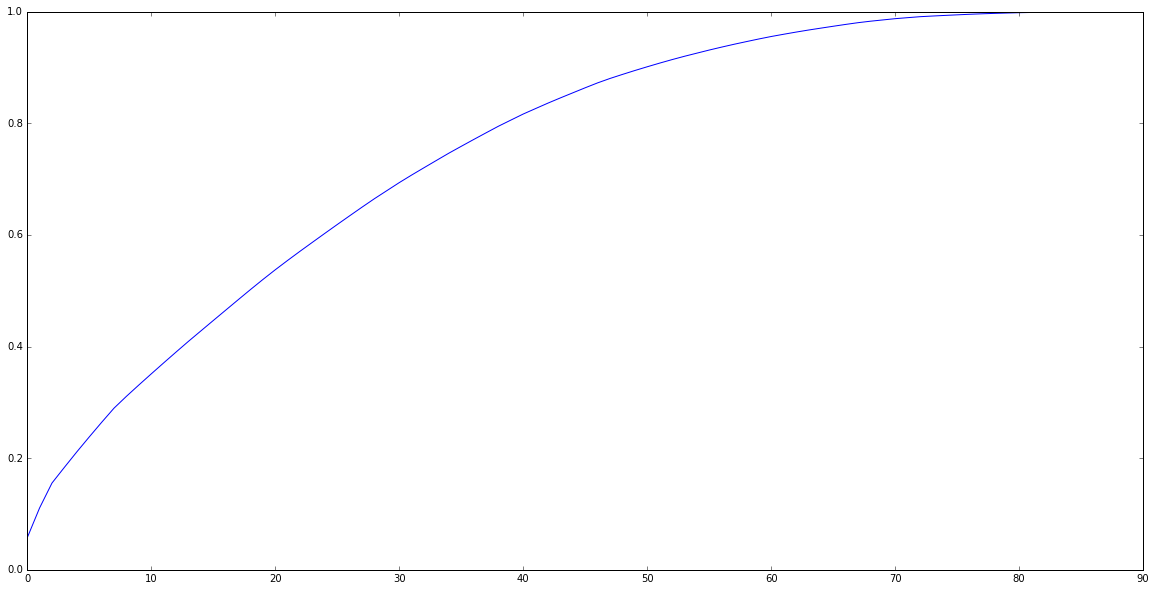

In [292]:
px, py = zip(*features)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(range(len(px)), np.cumsum(py));

[ 0.6375      0.58125     0.63125     0.58125     0.55        0.534375
  0.58125     0.54402516  0.56603774  0.54716981]


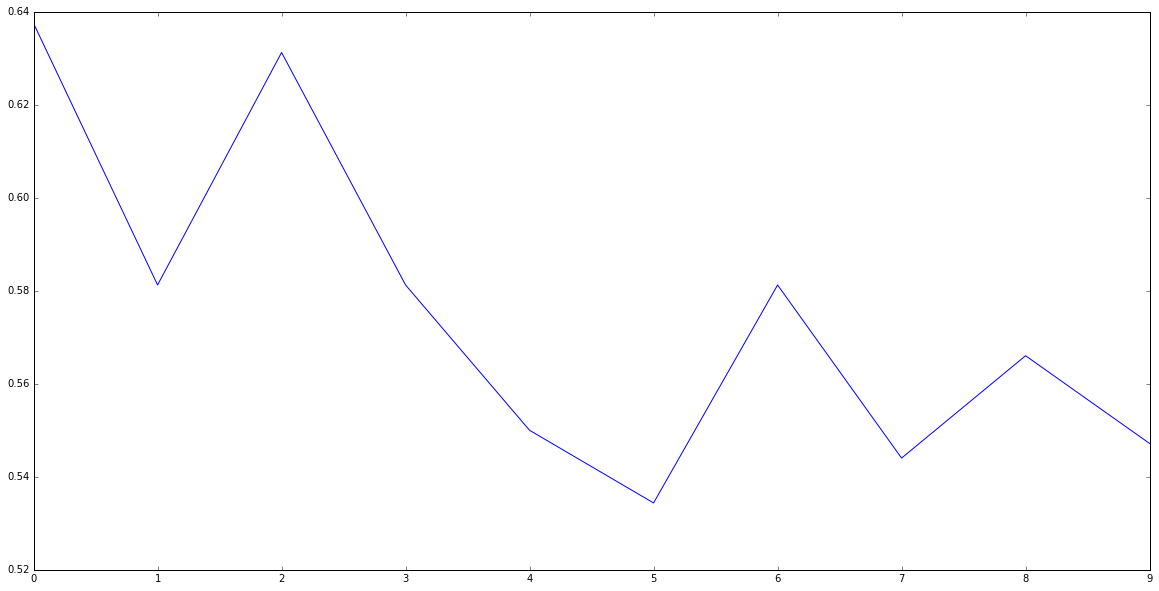

In [296]:
cv = StratifiedKFold(binarized_y['Yogurt'].as_matrix(),n_folds=10)
scores = cross_val_score(CV_rfc.best_estimator_, binarized_X, y=binarized_y, cv=cv, n_jobs=-1)
print scores

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot( range(len(scores)), scores);

In [297]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.58 (+/- 0.07)


In [299]:
rfc.oob_score

False